In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [103]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='yellow')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [104]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [105]:
class NeuralNet:
  
    
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000, precision = None):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.precision = precision
    
    def __normalize(self, X, mean = None, std = None):
       
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
       
        return 1 / (1 + np.exp(-Z))
    
    
    
    def __initialize_parameters(self):
        hidden_layer_sizes = self.hidden_layer_sizes
        parameters = {}
        for l in range(1, len(hidden_layer_sizes)):
            parameters['W' + str(l)] = np.random.randn(hidden_layer_sizes[l], hidden_layer_sizes[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((hidden_layer_sizes[l], 1))
        
        self.parameters = parameters


    def __forward_linear_activation(self, A_prev, W, b):
        
    
        Z = np.dot(W, A_prev) + b
        linear_cache = (A_prev, W, b)
        A = self.__sigmoid(Z)
        activation_cache = Z
        
        cache = (linear_cache, activation_cache)

        return A, cache
    
    def __multilayer_forward(self, X):       
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for l in range(1, L):
            A_prev = A 
            A, cache = self.__forward_linear_activation(A_prev, parameters["W"+str(l)], parameters["b"+str(l)])
            caches.append(cache)
            
        AL, cache = self.__forward_linear_activation(A, parameters["W"+str(L)], parameters["b"+str(L)])
        caches.append(cache)
        
        assert(AL.shape == (1,X.shape[1]))

        return AL, caches


    def __backward_linear_activation(self, dA, cache):
        
        linear_cache, activation_cache = cache
        
        Z = activation_cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dW = 1 / m * np.dot(dZ, A_prev.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        
        return dA_prev, dW, db


    def __multilayer_backward(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)

        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.__backward_linear_activation(dAL, current_cache)
        
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__backward_linear_activation(grads["dA" + str(l + 1)], current_cache)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
            
        return grads
    

    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __update_parameters(self, grads):
        parameters = self.parameters;
        learning_rate = self.learning_rate
        L = len(parameters) // 2

        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
            
        self.parameters = parameters;
        

    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):

            AL, caches = self.__multilayer_forward(X)
            
            cost = self.compute_cost(AL, Y)
            
            grads = self.__multilayer_backward(AL, Y, caches)
            
            self.__update_parameters(grads)
            
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)
                
                if len(costs) > 1 and self.precision != None and np.abs(costs[-2] - costs[-1]) < self.precision:
                    print('Stopping gradient descent ...')
                    break

        if print_cost:
                plt.plot(costs)
                plt.ylabel("Cost")
                plt.xlabel("Iteration, *100")
                plt.show()

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__multilayer_forward(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

In [106]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


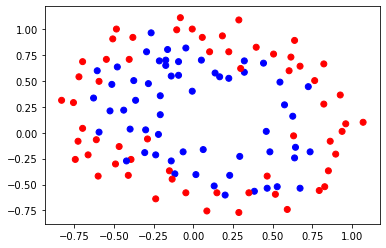

In [107]:
plot_data(X, Y)

In [108]:
cls = NeuralNet(hidden_layer_sizes = [2,2,1], normalize = True, learning_rate = 0.5, num_iter = 14000) 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)

Cost after iteration 0: 0.693196
Cost after iteration 100: 0.689483
Cost after iteration 200: 0.689403
Cost after iteration 300: 0.689239
Cost after iteration 400: 0.688954
Cost after iteration 500: 0.688584
Cost after iteration 600: 0.688191
Cost after iteration 700: 0.687706
Cost after iteration 800: 0.686864
Cost after iteration 900: 0.685063
Cost after iteration 1000: 0.681186
Cost after iteration 1100: 0.674129
Cost after iteration 1200: 0.662738
Cost after iteration 1300: 0.643075
Cost after iteration 1400: 0.616556
Cost after iteration 1500: 0.595416
Cost after iteration 1600: 0.582220
Cost after iteration 1700: 0.574293
Cost after iteration 1800: 0.569270
Cost after iteration 1900: 0.565836
Cost after iteration 2000: 0.563325
Cost after iteration 2100: 0.561389
Cost after iteration 2200: 0.559837
Cost after iteration 2300: 0.558555
Cost after iteration 2400: 0.557470
Cost after iteration 2500: 0.556534
Cost after iteration 2600: 0.555712
Cost after iteration 2700: 0.554982
Cost

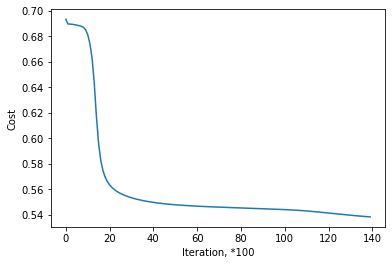

In [109]:
cls.fit(X_train, Y_train)

In [110]:
print(cls.parameters)

{'W1': array([[-1.55046745, -2.9817202 ],
       [-2.10462945, -2.32477212]]), 'b1': array([[ 8.80304358],
       [-8.72837771]]), 'W2': array([[ 6.2631989 , -7.20031457]]), 'b2': array([[-5.27509122]])}


In [111]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.72539774, 0.27460226],
       [0.6236827 , 0.3763173 ],
       [0.62145803, 0.37854197],
       [0.22511215, 0.77488785],
       [0.0266215 , 0.9733785 ],
       [0.68995209, 0.31004791],
       [0.01281182, 0.98718818],
       [0.72848715, 0.27151285],
       [0.72797768, 0.27202232],
       [0.70912841, 0.29087159],
       [0.72444245, 0.27555755],
       [0.26550604, 0.73449396],
       [0.25098615, 0.74901385],
       [0.17417349, 0.82582651],
       [0.66047426, 0.33952574],
       [0.72204695, 0.27795305],
       [0.70534793, 0.29465207],
       [0.72859292, 0.27140708],
       [0.67330357, 0.32669643],
       [0.59771057, 0.40228943],
       [0.72367699, 0.27632301],
       [0.68480966, 0.31519034],
       [0.70050416, 0.29949584],
       [0.08814931, 0.91185069],
       [0.72658959, 0.27341041],
       [0.67407554, 0.32592446],
       [0.19903105, 0.80096895],
       [0.67893418, 0.32106582],
       [0.64672349, 0.35327651],
       [0.71983806, 0.28016194],
       [0.

In [112]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1])

In [113]:
accuracy_score(Y, Y_hat)

0.711864406779661

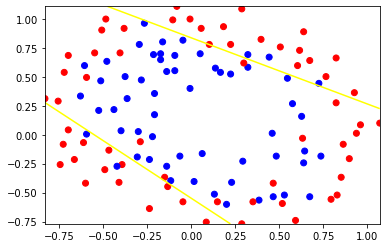

In [114]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [115]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [116]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

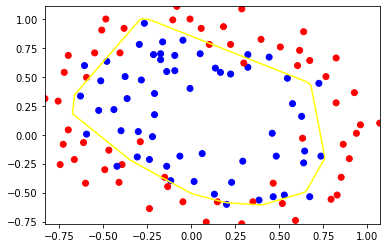

In [117]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [118]:
accuracy_score(Y, clf.predict(X))

0.864406779661017